In [ ]:
!pip install tensorflow-privacy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.2/323.2 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.8/104.8 kB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 27.3 MB/s eta 0:00:00
  Attempting uninstall: tensorflow-probability
    Found existing installation: tensorflow-probability 0.23.0
    Uninstalling tensorflow-probability-0.23.0:
      Successfully uninstalled tensorflow-probability-0.23.0
  Attempting uninstall: packaging
    Found existing installation: packaging 23.2
    Uninstalling packaging-23.2:
      Successfully uninstalled packaging-23.2


In [ ]:
import tensorflow as tf
import numpy as np
import tensorflow_privacy
from tensorflow_privacy.privacy.analysis import compute_dp_sgd_privacy

### loading data

In [ ]:
train, test = tf.keras.datasets.mnist.load_data()
train_data, train_labels = train
test_data, test_labels = test

# reshape
train_data = np.array(train_data, dtype=np.float32) / 255
test_data = np.array(test_data, dtype=np.float32) / 255

train_data = train_data.reshape(train_data.shape[0], 28, 28, 1)
test_data = test_data.reshape(test_data.shape[0], 28, 28, 1)

11490434/11490434 [==============================] - 0s 0us/step


In [ ]:
train_labels = np.array(train_labels, dtype=np.int32)
test_labels = np.array(test_labels, dtype=np.int32)

train_labels = tf.keras.utils.to_categorical(train_labels, num_classes=10)
test_labels = tf.keras.utils.to_categorical(test_labels, num_classes=10)

assert train_data.min() == 0.
assert train_data.max() == 1.
assert test_data.min() == 0.
assert test_data.max() == 1.

## building model

In [ ]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout

class Client:

  def __init__(self):

    # default hparams
    self.hp = {
        'epochs': 10,
        'batch_size': 32,
        'optim' : 'adam',
        'learning_rate' : 0.1,
        'loss' : 'categorical_crossentropy',
        'metric' : ['accuracy'],
        'l2_norm_clip' : None,
        'noise_multiplier' : None,
        'num_microbatches' : None

    }
    self.model = None


  def set_hyperparameters(self, epochs=None, batch_size=None, optim=None,
                          learning_rate=None, loss=None, metric=None,
                          l2_norm_clip=None, noise_multiplier=None, num_microbatches=None):
    if epochs is not None:
        self.hp['epochs'] = epochs
    if batch_size is not None:
        self.hp['batch_size'] = batch_size
    if optim is not None:
        self.hp['optim'] = optim
    if learning_rate is not None:
        self.hp['learning_rate'] = learning_rate
    if loss is not None:
        self.hp['loss'] = loss
    if metric is not None:
        self.hp['metric'] = metric
    if l2_norm_clip is not None:
        self.hp['l2_norm_clip'] = l2_norm_clip
    if noise_multiplier is not None:
        self.hp['noise_multiplier'] = noise_multiplier
    if num_microbatches is not None:
        self.hp['num_microbatches'] = num_microbatches



  def build_model(self):

    self.model = Sequential()
    # self.model.add(Conv2D(16, 8, strides=2, padding='same', activation='relu', input_shape=(28, 28, 1)))
    # self.model.add(MaxPool2D(2, 1))
    # self.model.add(Conv2D(32, 4, strides=2, padding='valid', activation='relu'))
    # self.model.add(MaxPool2D(2, 1))
    # self.model.add(Flatten())
    # self.model.add(Dense(32, activation='relu'))
    # self.model.add(Dropout(0.25))
    # self.model.add(Dense(10))
    self.model.add(Flatten(input_shape=(28, 28, 1)))
    self.model.add(Dense(128, activation='relu'))
    self.model.add(Dense(64, activation='relu'))
    self.model.add(Dropout(0.1))
    self.model.add(Dense(32, activation='relu'))
    self.model.add(Dense(10, activation='softmax'))

    self.hp['optim'] = tensorflow_privacy.DPKerasSGDOptimizer(
      l2_norm_clip = self.hp['l2_norm_clip'],
      noise_multiplier = self.hp['noise_multiplier'],
      num_microbatches = self.hp['num_microbatches'],
      learning_rate = self.hp['learning_rate']
    )


    self.hp['loss'] = tf.keras.losses.CategoricalCrossentropy(
           from_logits=True, reduction=tf.losses.Reduction.NONE)

    self.model.compile(loss=self.hp['loss'],
                       optimizer=self.hp['optim'],
                       metrics=self.hp['metric'])


  def train(self, train_data, train_labels, test_data, test_labels):
    self.model.fit(train_data, train_labels,
          epochs=self.hp['epochs'],
          validation_data=(test_data, test_labels),
          batch_size=self.hp['batch_size'])

In [ ]:
L2NC = 1.5
NoiseMult = 1.3
MicroBatch = 250
LR = 0.25
BATCH=250
EPOCHS=10

if BATCH % MicroBatch != 0:
  raise ValueError('Batch size should be an integer multiple of the number of microbatches')


In [ ]:
c=Client()
c.set_hyperparameters(epochs=EPOCHS,
                      batch_size=BATCH,
                      learning_rate=LR,
                      l2_norm_clip=L2NC,
                      noise_multiplier=NoiseMult,
                      num_microbatches=MicroBatch)
c.build_model()

In [ ]:
c.train(train_data, train_labels, test_data, test_labels)

Epoch 1/10
240/240 [==============================] - 22s 88ms/step - loss: 1.0583 - accuracy: 0.6683 - val_loss: 0.5098 - val_accuracy: 0.8529
Epoch 2/10
240/240 [==============================] - 21s 87ms/step - loss: 0.6118 - accuracy: 0.8333 - val_loss: 0.4656 - val_accuracy: 0.8816
Epoch 3/10
240/240 [==============================] - 20s 83ms/step - loss: 0.5745 - accuracy: 0.8607 - val_loss: 0.4551 - val_accuracy: 0.8916
Epoch 4/10
240/240 [==============================] - 20s 84ms/step - loss: 0.5532 - accuracy: 0.8726 - val_loss: 0.4541 - val_accuracy: 0.8975
Epoch 5/10
240/240 [==============================] - 21s 85ms/step - loss: 0.5400 - accuracy: 0.8798 - val_loss: 0.4572 - val_accuracy: 0.9015
Epoch 6/10
240/240 [==============================] - 20s 84ms/step - loss: 0.5444 - accuracy: 0.8849 - val_loss: 0.4481 - val_accuracy: 0.9056
Epoch 7/10
240/240 [==============================] - 21s 86ms/step - loss: 0.5382 - accuracy: 0.8899 - val_loss: 0.4404 - val_accuracy:

In [ ]:
print(tensorflow_privacy.compute_dp_sgd_privacy_statement(number_of_examples=train_data.shape[0],
                                                    batch_size = BATCH,
                                                    noise_multiplier= NoiseMult,
                                                    num_epochs = EPOCHS,
                                                    delta = 1e-5))

DP-SGD performed over 60000 examples with 250 examples per iteration, noise
multiplier 1.3 for 10 epochs with microbatching, and no bound on number of
examples per user.

This privacy guarantee protects the release of all model checkpoints in addition
to the final model.

Example-level DP with add-or-remove-one adjacency at delta = 1e-05 computed with
RDP accounting:
    Epsilon with each example occurring once per epoch:        33.795
    Epsilon assuming Poisson sampling (*):                      4.499

No user-level privacy guarantee is possible without a bound on the number of
examples per user.

(*) Poisson sampling is not usually done in training pipelines, but assuming
that the data was randomly shuffled, it is believed that the actual epsilon
should be closer to this value than the conservative assumption of an arbitrary
data order.



In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

loss_acc = pd.DataFrame(

{
    'train_loss': [1.0583, 0.6118, 0.5745, 0.5532, 0.5400, 0.5444, 0.5382, 0.5337, 0.5207, 0.5176],
    'train_acc': [0.6683, 0.8333, 0.8607, 0.8726, 0.8798, 0.8849, 0.8899, 0.8935, 0.8952, 0.8992],

    'val_loss': [0.5098, 0.4656, 0.4551, 0.4541, 0.4572, 0.4481, 0.4404, 0.4291, 0.4312, 0.4182],
    'val_acc':  [0.8529, 0.8816, 0.8916, 0.8975, 0.9015, 0.9056, 0.9097, 0.9128, 0.9136, 0.9179]
}
)
loss_acc

,train_loss,train_acc,val_loss,val_acc
0,1.0583,0.6683,0.5098,0.8529
1,0.6118,0.8333,0.4656,0.8816
2,0.5745,0.8607,0.4551,0.8916
3,0.5532,0.8726,0.4541,0.8975
4,0.5400,0.8798,0.4572,0.9015
5,0.5444,0.8849,0.4481,0.9056
6,0.5382,0.8899,0.4404,0.9097
7,0.5337,0.8935,0.4291,0.9128
8,0.5207,0.8952,0.4312,0.9136
9,0.5176,0.8992,0.4182,0.9179


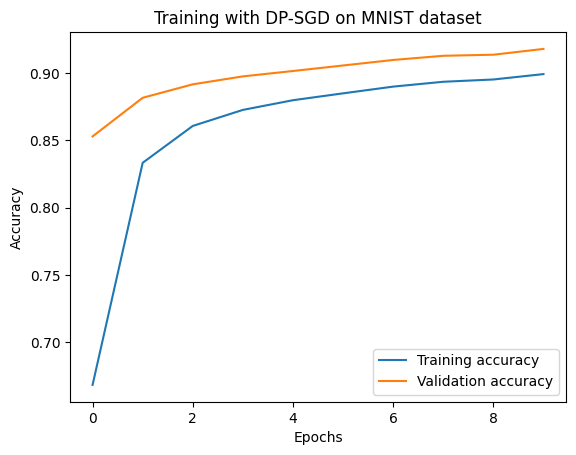

In [ ]:
plt.title('Training with DP-SGD on MNIST dataset')
plt.plot(loss_acc["train_acc"], label='Training accuracy')
plt.plot(loss_acc['val_acc'], label='Validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.show()